# Collaborative Filtering

Collaborative Filtering is a technique to filter out products for a certain user based on the similarity of other users. We need a set of items, a set of users and rating to do collaborative filtering. <p>
Since we do not have rating features here, we are going to use the reordered features. For this model, we are using the last 5 order numbers from each customer. However, not every customer have 5, some can have less than 5. For that reasons, I am using the features 'i_prob_per_oder' as rating which is the probability of each item reordered each time based on each customer.

### Importing the libraries

In [2]:
# Import the basic packages
import numpy as np 
import pandas as pd 
from zipfile import ZipFile
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Import the surprise packages
from surprise import Dataset
from surprise.reader import Reader
from surprise import KNNWithMeans, SVD, BaselineOnly
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD

# Import train_test_split, GridSearchCV, cross validate
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise import accuracy
from surprise.accuracy import rmse

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# read df_used
df_used = pd.read_csv('df_used.csv')

In [65]:
df_used.head()

,user_id,product_id,reordered,u_i_count,u_i_max_order,i_prob_per_order,u_i_reordered,u_i_ratio_reordered,u_total_order,avg_u_order,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,1,196.0,1.0,5,5,1.0,5,1.0,11,7.0,...,0,0,0,0,0,0,0,0,0,0
1,1,10258.0,1.0,5,5,1.0,5,1.0,11,7.0,...,0,0,0,0,0,0,0,0,0,1
2,1,12427.0,1.0,4,5,0.8,4,0.8,11,7.0,...,0,0,0,0,0,0,0,0,0,1
3,1,25133.0,1.0,5,5,1.0,5,1.0,11,7.0,...,0,0,0,0,0,0,0,0,0,0
4,1,13032.0,1.0,3,5,0.6,3,0.6,11,7.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# getting the product and department 
products = pd.read_csv('products.csv')
dept = pd.read_csv('departments.csv')
prod_dept = pd.merge(products, dept, on='department_id', how='left')

### Adjusting Dataframe

We need to create a dataframe consists mainly user_id, product_id, rating and product_name.

In [5]:
# just grab the columns needed: user_id, product_id and i_prob_per_order
rating_ = df_used[['user_id', 'product_id', 'i_prob_per_order']]

In [6]:
# merger with rating_
rating_ = pd.merge(rating_, products[['product_id', 'product_name']], 
                    on='product_id', how='left' )
rating_.head()

,user_id,product_id,i_prob_per_order,product_name
0,1,196.0,1.0,Soda
1,1,10258.0,1.0,Pistachios
2,1,12427.0,0.8,Original Beef Jerky
3,1,25133.0,1.0,Organic String Cheese
4,1,13032.0,0.6,Cinnamon Toast Crunch


In [58]:
rating_.shape

(10193312, 4)

In [7]:
# drop duplicates
rating_ = rating_.drop_duplicates()

In [8]:
# rename 'i_prob_per_order' as rating
rating_.rename(columns={'i_prob_per_order' : 'rating'}, inplace=True)
rating_.head()

,user_id,product_id,rating,product_name
0,1,196.0,1.0,Soda
1,1,10258.0,1.0,Pistachios
2,1,12427.0,0.8,Original Beef Jerky
3,1,25133.0,1.0,Organic String Cheese
4,1,13032.0,0.6,Cinnamon Toast Crunch


In [72]:
# rating_ = df.used without duplicates
rating_.shape

(6910976, 4)

Due to computational limitations, I will only use the first 100,000 rows for the surprise model: FunkSVD and ALS.

In [9]:
# using only user_id 1 - 100,000
rating_df = rating_.head(100000)


In [11]:
# check the dataset
print('Shape: ', rating_df.shape)
print('Number of Unique user_id:',len(rating_df['user_id'].unique()))
print('Number of Unique products:',len(rating_df['product_id'].unique()))

Shape:  (100000, 4)
Number of Unique user_id: 3014
Number of Unique products: 17971


In [20]:
# check if there is null values in the rating
rating_df[rating_df['rating'].isna()]

,user_id,product_id,rating,product_name


In [77]:
# check for user id == 1
rating_df[rating_df['user_id']==1].product_name.unique()

array(['Soda', 'Pistachios', 'Original Beef Jerky',
       'Organic String Cheese', 'Cinnamon Toast Crunch',
       'Zero Calorie Cola', 'Organic Half & Half',
       'Milk Chocolate Almonds', '0% Greek Strained Yogurt',
       'Organic Unsweetened Almond Milk',
       'XL Pick-A-Size Paper Towel Rolls', 'Aged White Cheddar Popcorn',
       'Organic Whole Milk'], dtype=object)

In [43]:
# Check the min and max value of rating columns
print(f'Min:{rating_df["rating"].min()}')
print(f'Max:{rating_df["rating"].max()}')

Min:0.2
Max:1.0


In [45]:
# Set the reader with accurate rating scale
reader = Reader(rating_scale=(0.2,1))

# Set the dataset
# df parameter has to have 3 columns:
# User ids, product ids and ratings
data = Dataset.load_from_df(rating_df[['user_id','product_id','rating']], reader)
data

For this user based approach, I am going to use FunkSVD, SVD, KNNWithMeans and BaselineOnly. They works using matrix factorization which it decomposes high dimensional user-item matrix into low dimensional user matrix and item matrix. User matrix: each row represents a user and each column is latent factors. Item matrix: each row is latent factor and each column represent an item. Matrix factorization then use latent factors to represent user or item preferences so it can give recommendation.

### FunkSVD

The measurement metric used is fcp.

In [46]:
# Set the parameter grid
param_grid = {
    'n_factors': [50, 100], 
    'n_epochs': [10, 20],
    'lr_all': [0.005, 0.007],
    'biased': [False]}

# Set GridSearchCV with 3 cross validation
gs = GridSearchCV(FunkSVD, param_grid, measures=['fcp'], cv=3)

# Fit the model
gs.fit(data)

In [47]:
# Check the FCP accuracy score (1.0 is ideal and 0 is worst)
print(f"Best score: {gs.best_score['fcp']}")
# Check the best parameters
print(f"Best parameter: {gs.best_params['fcp']}")

Best score: 0.2448318949780185
Best parameter: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.007, 'biased': False}


Based on best parameter, we can build algorithm on train and test set to check the accuracy based on the prediction values.

In [48]:
# Split train test set
train, test = train_test_split(data, test_size=0.2)

# Set the algorithm
svd = FunkSVD(n_factors=100, n_epochs=20, lr_all=0.007, biased=False, verbose=0)
# Fit train set
svd.fit(train)

# Test the algorithm using test set
pred = svd.test(test)

In [49]:
# Put my_pred result in a dataframe
svd_pred_df = pd.DataFrame(pred, columns=['user_id',
                                        'product_id',
                                        'actual',
                                        'prediction',
                                        'details'])

# Calculate the difference of actual and prediction into diff column
svd_pred_df['diff'] = abs(svd_pred_df['prediction'] - 
                            svd_pred_df['actual'])

In [50]:
# Check the svd_pred_df
svd_pred_df.head()

,user_id,product_id,actual,prediction,details,diff
0,1935,47966.0,0.2,0.200000,{'was_impossible': False},0.000000
1,1483,3628.0,1.0,0.200000,{'was_impossible': False},0.800000
2,1332,39475.0,0.2,0.200000,{'was_impossible': False},0.000000
3,1071,7360.0,0.2,0.306483,"{'was_impossible': True, 'reason': 'User and i...",0.106483
4,1847,23265.0,0.4,0.200000,{'was_impossible': False},0.200000


In [53]:
# Build full trainset
train_df = data.build_full_trainset()

# Build the SVD algorithm
my_svd = FunkSVD(n_factors=100, 
                 n_epochs=10, 
                 lr_all=0.007,    
                 biased=False, 
                 verbose=0)

# Fit with full trainset
my_svd.fit(train_df)

In [60]:
# Define the full test set
test_df = train_df.build_anti_testset(fill=-1)

In [61]:
# set the prediction
pred = my_svd.test(test_df)

In [62]:
# Put into a dataframe
pred_df = pd.DataFrame(pred, columns=['user_id', 'product_id','actual', 'prediction','details'])                                 

In [75]:
def recommender_FunkSVD(uid):
    '''
    Given a user_id, recommend new product using FunkSVD.
    uid: user_id
    '''
    # check user_id prediction in pred_df
    user_df = pred_df[pred_df['user_id'] == uid]
    user_df = user_df.sort_values('prediction', ascending=False)
    # merge with rating_df
    df = user_df.merge(rating_df[['product_id', 'product_name']].drop_duplicates(), how='left', 
                    on = 'product_id')
    return df.head(10)


In [76]:
recommender_FunkSVD(1)

,user_id,product_id,actual,prediction,details,product_name
0,1,13252.0,-1.0,0.362472,{'was_impossible': False},Baguette Sourdough
1,1,25368.0,-1.0,0.359813,{'was_impossible': False},Complete Powder
2,1,17987.0,-1.0,0.349959,{'was_impossible': False},Creamy Wheat Hot Cereal
3,1,33495.0,-1.0,0.329810,{'was_impossible': False},Manzanilla Pimiento Stuffed Olives
4,1,40781.0,-1.0,0.328169,{'was_impossible': False},Seasoned Turkey Burger
5,1,2826.0,-1.0,0.327593,{'was_impossible': False},Blue Corn Chip Bowls
6,1,48142.0,-1.0,0.324245,{'was_impossible': False},Diet
7,1,421.0,-1.0,0.323360,{'was_impossible': False},Garlic & Herb Fresh Goat Cheese
8,1,3892.0,-1.0,0.323192,{'was_impossible': False},No-Scratch Refills
9,1,43590.0,-1.0,0.317878,{'was_impossible': False},Chocolate Cupcake


The top recommendations using Funk_SVD for user 1 is Baquette Sourdough.

### SVD, KNNWtihMeans and BaselineOnly

Comparing the accuracy metric (rmse) of SVD, KNNWithMeans and BaselineOnly to decide which model to use. 


In [12]:
# Set the reader with accurate rating scale
reader = Reader(rating_scale=(0.2,1))

# Set the dataset
# df parameter has to have 3 columns:
# User ids, product ids and ratings
data = Dataset.load_from_df(rating_df[['user_id','product_id','rating']], reader)
data

Testing several algorithm using rmse as the accuracy metric.

In [18]:
acc = []
for algo in [SVD(), KNNWithMeans(), BaselineOnly()]:
    # perform cross validation
    results = cross_validate(algo, data, measures = ['rmse'], cv=3, verbose=0)
    # get results
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    temp = temp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    acc.append(temp)

/var/folders/7n/qn9xwtc50ws_9tjv988jvnwm0000gn/T/ipykernel_875/880837798.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/7n/qn9xwtc50ws_9tjv988jvnwm0000gn/T/ipykernel_875/880837798.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


/var/folders/7n/qn9xwtc50ws_9tjv988jvnwm0000gn/T/ipykernel_875/880837798.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))


In [19]:
# make a dataframe for the results
acc_results = pd.DataFrame(acc).set_index('Algorithm').sort_values('test_rmse')
acc_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.169761,0.280534,0.189080
KNNWithMeans,0.182280,0.502991,1.793969
SVD,0.183612,4.346705,0.254670


The BaselineOnly give the best test_rsme. So, we are going to Baseline ALS.

In [20]:
# algorithm and cross validation
bsl_options = {'method': 'als', 'n_epochs': 5, 'reg_u' : 12, 'reg_i':5 }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['rmse'], cv=3, verbose=0)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.16991095, 0.17071427, 0.16950125]),
 'fit_time': (0.14738917350769043, 0.16742396354675293, 0.18449902534484863),
 'test_time': (0.14118409156799316, 0.14026904106140137, 0.2520918846130371)}

In [23]:
# Split train test set
trainset, testset = train_test_split(data, test_size=0.2)
algo = BaselineOnly(bsl_options=bsl_options)
als_pred = algo.fit(trainset).test(testset)
accuracy.rmse(als_pred)

Estimating biases using als...
RMSE: 0.1694


0.16941907626126135

In [66]:
# Build full trainset
full_trainset = data.build_full_trainset()

# Build the algorithm
bsl_options = {'method': 'als', 'n_epochs': 5, 'reg_u' : 12, 'reg_i':5 }
algo = BaselineOnly(bsl_options=bsl_options)

# Fit with full trainset
algo.fit(full_trainset)

Estimating biases using als...


In [67]:
# Define the full test set
full_testset = full_trainset.build_anti_testset(fill=-1)

In [68]:
# prediction
my_prediction = algo.test(full_testset)

In [70]:
# make a dataframe
df_pred_als = pd.DataFrame(my_prediction, columns=['user_id', 'product_id',
                            'actual', 'prediction', 'deatils'])

In [73]:
def recommender_als(uid):
    '''
    Given a user id, recommend product using als model.
    uid: user id
    '''
    # check user_id prediction in df_pred_als
    user_df = df_pred_als[df_pred_als['user_id'] == uid]
    user_df = user_df.sort_values('prediction', ascending=False)
    # merge with rating_df
    df = user_df.merge(rating_df[['product_id', 'product_name']].drop_duplicates(), how='left', 
                    on = 'product_id')
    return df.head(10)


In [74]:
# recommender based on als
recommender_als(1)

,user_id,product_id,actual,prediction,deatils,product_name
0,1,20339.0,-1.0,0.648802,{'was_impossible': False},Chocolate Protein Soy & Dairy Protein Shake
1,1,40174.0,-1.0,0.629267,{'was_impossible': False},2% Reduced Fat Organic Milk
2,1,48041.0,-1.0,0.627592,{'was_impossible': False},DanActive Vanilla Probiotic Dairy Drink
3,1,19660.0,-1.0,0.622873,{'was_impossible': False},Spring Water
4,1,13176.0,-1.0,0.618814,{'was_impossible': False},Bag of Organic Bananas
5,1,43693.0,-1.0,0.617536,{'was_impossible': False},Whole Vitamin D Milk
6,1,31257.0,-1.0,0.615865,{'was_impossible': False},Vegan Chocolate Chip Mini Muffins
7,1,24852.0,-1.0,0.615062,{'was_impossible': False},Banana
8,1,43394.0,-1.0,0.611021,{'was_impossible': False},Organic Lactose Free Whole Milk
9,1,31981.0,-1.0,0.607495,{'was_impossible': False},1% Low Fat Milk


Top recommendation using als for user 1 is chocolate protein soy & dairy protein shake.

## Neural Networks

For Collaborative filtering neural network, I following the code from https://keras.io/examples/structured_data/collaborative_filtering_movielens/.

To recommend products using neural network, there are 4 steps:
1. map user_id to a user vector via an embedding matrix
2. map product_id to a product vector via an embedding matrix
3. compute the dot product between the two vectors to get a match score 
4. train the embeddings via gradient descent using all known user-product pairs

In [10]:
# using rating_df as the dataframe
# preprocessing to encode users as integer indices
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

# preprocessing to encode products as integer indices
product_ids = rating_df["product_id"].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded2product = {i: x for i, x in enumerate(product_ids)}
rating_df["product"] = rating_df["product_id"].map(product2product_encoded)

num_users = len(user2user_encoded)
num_products = len(product_encoded2product)
rating_df["rating"] = rating_df["rating"].values.astype(np.float32)

# min and max rating will be used to normalize the rating later
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

print(
    "Number of users: {}, Number of products: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_products, min_rating, max_rating))

Number of users: 3014, Number of products: 17971, Min rating: 0.20000000298023224, Max rating: 1.0


/tmp/ipykernel_526/692516029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
/tmp/ipykernel_526/692516029.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["product"] = rating_df["product_id"].map(product2product_encoded)
/tmp/ipykernel_526/692516029.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In here, I only split the data into train and validation set. 

In [13]:
# preparing Training and validation data
rating = rating_df.sample(frac=1, random_state=42)
x = rating[["user", "product"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = rating["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [14]:
# embed movie and users in to EMBEDDING_SIZE dimentional vectors
EMBEDDING_SIZE = 10

# create a model to compute a dot product between user and products and add bias
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_products, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            # using 'he_normal' as initializer
            embeddings_initializer="he_normal",
            # using l2 as regulizers
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(
            num_products,
            embedding_size,
            # using 'he_normal' as initializer
            embeddings_initializer="he_normal",
            # using l2 as regulizers
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        # get user vector
        user_vector = self.user_embedding(inputs[:, 0])
        # get user bias
        user_bias = self.user_bias(inputs[:, 0])
        # get product vector
        product_vector = self.product_embedding(inputs[:, 1])
        # get product bias
        product_bias = self.product_bias(inputs[:, 1])
        # get dot product between user and product vectors
        dot_user_product = tf.tensordot(user_vector, product_vector, 2)
        # Add all the components (including bias)
        x = dot_user_product + user_bias + product_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [15]:
# using learning_rate = 0.001
model = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model.compile(
    # using binary crossentropy as loss function
    loss=tf.keras.losses.BinaryCrossentropy(),
    # using Adam as optimizers
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # provide accuracy metric
    metrics=['accuracy']
)

2022-11-16 04:23:16.989453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# train model based on the data split
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
313/313 [==============================] - 3s 5ms/step - loss: 0.6239 - accuracy: 0.5457 - val_loss: 0.4341 - val_accuracy: 0.6191
Epoch 2/10
313/313 [==============================] - 1s 4ms/step - loss: 0.3895 - accuracy: 0.6212 - val_loss: 0.4091 - val_accuracy: 0.6191
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 0.3851 - accuracy: 0.6212 - val_loss: 0.4088 - val_accuracy: 0.6191
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 0.3810 - accuracy: 0.6212 - val_loss: 0.4017 - val_accuracy: 0.6191
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 0.3768 - accuracy: 0.6212 - val_loss: 0.4006 - val_accuracy: 0.6191
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 0.3731 - accuracy: 0.6212 - val_loss: 0.3982 - val_accuracy: 0.6191
Epoch 7/10
313/313 [==============================] - 1s 4ms/step - loss: 0.3694 - accuracy: 0.6212 - val_loss: 0.3970 - val_accuracy: 0.6192
Epoch 

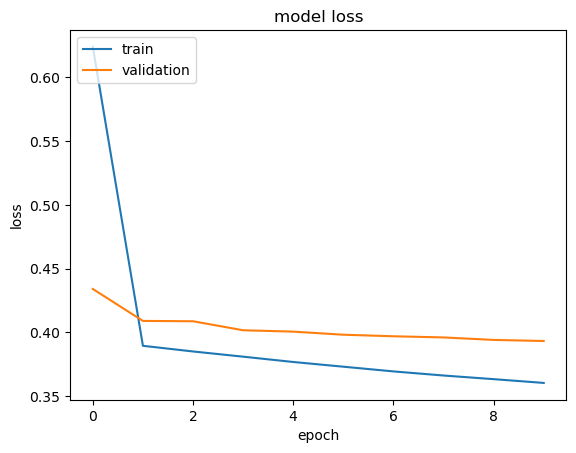

In [18]:
# plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

The validation set is overfitting. We can try to lower the learning rate, do not use the initializer and regularizer, use smaller batch size and more epochs.

In [31]:
# embed movie and users in to EMBEDDING_SIZE dimentional vectors
EMBEDDING_SIZE = 20

# create a model to compute a dot product between user and products and add bias
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_products, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(
            num_products,
            embedding_size,
        )
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        # get user vector
        user_vector = self.user_embedding(inputs[:, 0])
        # get user bias
        user_bias = self.user_bias(inputs[:, 0])
        # get product vector
        product_vector = self.product_embedding(inputs[:, 1])
        # get product bias
        product_bias = self.product_bias(inputs[:, 1])
        # get dot product between user and product vectors
        dot_user_product = tf.tensordot(user_vector, product_vector, 2)
        # Add all the components (including bias)
        x = dot_user_product + user_bias + product_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [32]:
# using learning_rate = 0.0005
model = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model.compile(
    # using binary crossentropy as loss function
    loss=tf.keras.losses.BinaryCrossentropy(),
    # using Adam as optimizers
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    # provide accuracy metric
    metrics=['accuracy'])

In [33]:
# use lower batch size and more epochs
# train model based on the data split
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/30
1250/1250 [==============================] - 10s 7ms/step - loss: 0.6589 - accuracy: 0.5297 - val_loss: 0.5916 - val_accuracy: 0.6191
Epoch 2/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4289 - accuracy: 0.6212 - val_loss: 0.4087 - val_accuracy: 0.6191
Epoch 3/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3876 - accuracy: 0.6212 - val_loss: 0.4154 - val_accuracy: 0.6191
Epoch 4/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3818 - accuracy: 0.6212 - val_loss: 0.4132 - val_accuracy: 0.6191
Epoch 5/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3771 - accuracy: 0.6212 - val_loss: 0.4088 - val_accuracy: 0.6191
Epoch 6/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3725 - accuracy: 0.6212 - val_loss: 0.4106 - val_accuracy: 0.6191
Epoch 7/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3687 - accuracy: 0.6213 - val_loss: 0.4096 - val_accuracy

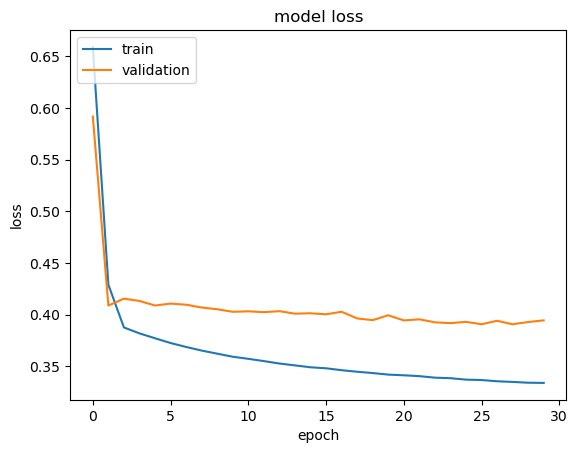

In [34]:
# plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

The data seems to be overfitting. Maybe we can use more data (using rating_ as the dataframe).

### Using the rating_ dataframe to run in Neural Network

In [61]:
rating_.head()

,user_id,product_id,rating,product_name
0,1,196.0,1.0,Soda
1,1,10258.0,1.0,Pistachios
2,1,12427.0,0.8,Original Beef Jerky
3,1,25133.0,1.0,Organic String Cheese
4,1,13032.0,0.6,Cinnamon Toast Crunch


In [62]:
# preprocessing to encode users as integer indices
user_ids = rating_["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
rating_["user"] = rating_["user_id"].map(user2user_encoded)

# preprocessing to encode products as integer indices
product_ids = rating_["product_id"].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded2product = {i: x for i, x in enumerate(product_ids)}
rating_["product"] = rating_["product_id"].map(product2product_encoded)

num_users = len(user2user_encoded)
num_products = len(product_encoded2product)
rating_["rating"] = rating_["rating"].values.astype(np.float32)

# min and max rating will be used to normalize the rating later
min_rating = min(rating_["rating"])
max_rating = max(rating_["rating"])

print(
    "Number of users: {}, Number of products: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_products, min_rating, max_rating))

Number of users: 206209, Number of products: 48867, Min rating: 0.20000000298023224, Max rating: 1.0


In [63]:
# preparing Training and validation data
rating = rating_.sample(frac=1, random_state=42)
x = rating[["user", "product"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = rating["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [64]:
# embed movie and users in to EMBEDDING_SIZE dimentional vectors
EMBEDDING_SIZE = 10

# create a model to compute a dot product between user and products and add bias
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_products, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            # using 'he_normal' as initializer
            embeddings_initializer="he_normal",
            # using l2 as regulizers
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(
            num_products,
            embedding_size,
            # using 'he_normal' as initializer
            embeddings_initializer="he_normal",
            # using l2 as regulizers
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        product_vector = self.product_embedding(inputs[:, 1])
        product_bias = self.product_bias(inputs[:, 1])
        # get dot product between user and product vectors
        dot_user_product = tf.tensordot(user_vector, product_vector, 2)
        # Add all the components (including bias)
        x = dot_user_product + user_bias + product_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


In [32]:
# using learning_rate = 0.001
model = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model.compile(
    # using binary crossentropy as loss function
    loss=tf.keras.losses.BinaryCrossentropy(),
    # using Adam as optimizers      
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [33]:
# train model based on the data split
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
21597/21597 [==============================] - 419s 19ms/step - loss: 0.3993 - val_loss: 0.3875
Epoch 2/5
21597/21597 [==============================] - 373s 17ms/step - loss: 0.3881 - val_loss: 0.3944
Epoch 3/5
21597/21597 [==============================] - 374s 17ms/step - loss: 0.3918 - val_loss: 0.3985
Epoch 4/5
21597/21597 [==============================] - 374s 17ms/step - loss: 0.3949 - val_loss: 0.4024
Epoch 5/5
21597/21597 [==============================] - 373s 17ms/step - loss: 0.3970 - val_loss: 0.4047


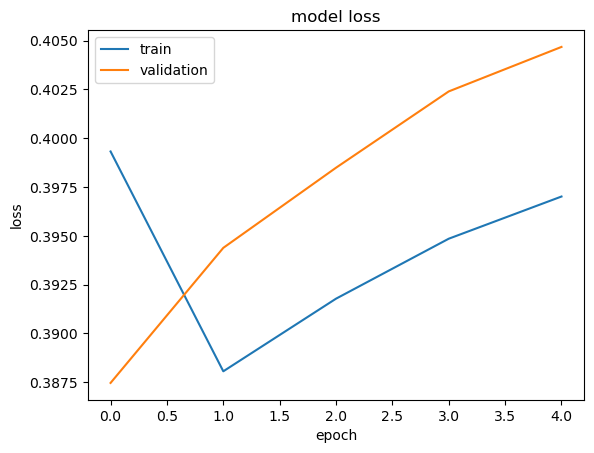

In [34]:
# plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

The loss of both train and validation set is getting higher, we can try to lower the learning rate and add accuracy metric.

In [68]:
# using learning_rate = 0.0001
model1 = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model1.compile(
    # using binary crossentropy as loss function
    loss=tf.keras.losses.BinaryCrossentropy(),
    # using Adam as optimizers
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    # provide accuracy metric
    metrics=['accuracy'])

In [69]:
# train model based on the data split
history1 = model1.fit(
        x=x_train,
        y=y_train,
        batch_size=256,
        epochs=10,
        verbose=1,
        validation_data=(x_val, y_val))

Epoch 1/10
21597/21597 [==============================] - 375s 17ms/step - loss: 0.4489 - accuracy: 0.5948 - val_loss: 0.3846 - val_accuracy: 0.6165
Epoch 2/10
21597/21597 [==============================] - 374s 17ms/step - loss: 0.3814 - accuracy: 0.6163 - val_loss: 0.3788 - val_accuracy: 0.6165
Epoch 3/10
21597/21597 [==============================] - 374s 17ms/step - loss: 0.3765 - accuracy: 0.6163 - val_loss: 0.3755 - val_accuracy: 0.6165
Epoch 4/10
21597/21597 [==============================] - 374s 17ms/step - loss: 0.3732 - accuracy: 0.6163 - val_loss: 0.3730 - val_accuracy: 0.6165
Epoch 5/10
21597/21597 [==============================] - 375s 17ms/step - loss: 0.3705 - accuracy: 0.6163 - val_loss: 0.3710 - val_accuracy: 0.6165
Epoch 6/10
21597/21597 [==============================] - 373s 17ms/step - loss: 0.3683 - accuracy: 0.6163 - val_loss: 0.3693 - val_accuracy: 0.6165
Epoch 7/10
21597/21597 [==============================] - 374s 17ms/step - loss: 0.3664 - accuracy: 0.6163

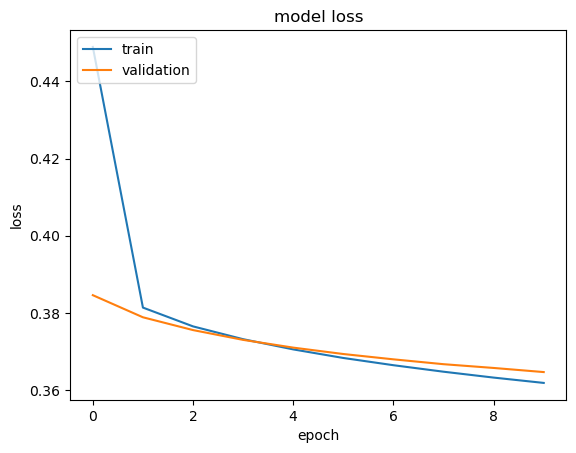

In [72]:
# plot training and validation loss
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

Since the accuracy above does not improve, I am trying to increase embedding size to see if there is any difference.

In [78]:
# using embedding_size 15 instead of 10
EMBEDDING_SIZE = 15
# using learning_rate = 0.0001
model = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model.compile(
    # using binary crossentropy as loss function
    loss=tf.keras.losses.BinaryCrossentropy(),
    # using Adam as optimizers
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    # provide accuracy metric
    metrics=[keras.metrics.BinaryAccuracy()])

In [76]:
# train model based on the data split
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=256,
        epochs=10,
        verbose=1,
        validation_data=(x_val, y_val))

Epoch 1/10
21597/21597 [==============================] - 584s 27ms/step - loss: 0.4380 - binary_accuracy: 0.5978 - val_loss: 0.3844 - val_binary_accuracy: 0.6165
Epoch 2/10
21597/21597 [==============================] - 570s 26ms/step - loss: 0.3812 - binary_accuracy: 0.6163 - val_loss: 0.3789 - val_binary_accuracy: 0.6165
Epoch 3/10
21597/21597 [==============================] - 567s 26ms/step - loss: 0.3766 - binary_accuracy: 0.6163 - val_loss: 0.3757 - val_binary_accuracy: 0.6165
Epoch 4/10
21597/21597 [==============================] - 567s 26ms/step - loss: 0.3733 - binary_accuracy: 0.6163 - val_loss: 0.3731 - val_binary_accuracy: 0.6165
Epoch 5/10
21597/21597 [==============================] - 568s 26ms/step - loss: 0.3707 - binary_accuracy: 0.6163 - val_loss: 0.3711 - val_binary_accuracy: 0.6165
Epoch 6/10
21597/21597 [==============================] - 565s 26ms/step - loss: 0.3685 - binary_accuracy: 0.6163 - val_loss: 0.3695 - val_binary_accuracy: 0.6165
Epoch 7/10
21597/21597

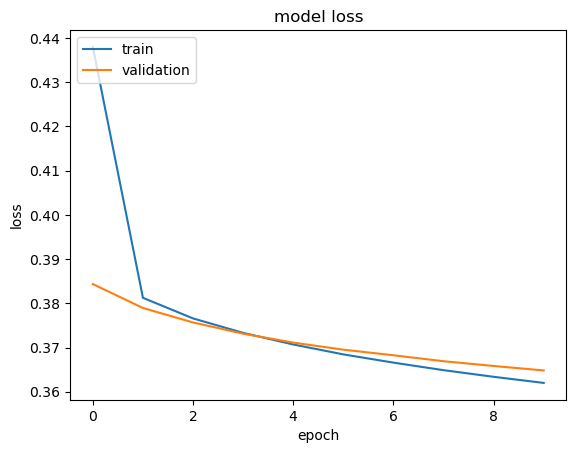

In [77]:
# plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

Since the accuracy more or less the same when adding embedding size, I want to run another model using original embedding_size=10, smaller learning_rate=0.0001, longer epoch to 15 and smaller batch_size=128.

In [81]:
EMBEDDING_SIZE = 10
# using learning_rate = 0.00001
model = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model.compile(
    # using binary crossentropy as loss function
    loss=tf.keras.losses.BinaryCrossentropy(),
    # using Adam as optimizers
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    # provide accuracy metric
    metrics=[keras.metrics.BinaryAccuracy()])

In [82]:
# train model based on the data split
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=15,
        verbose=1,
        validation_data=(x_val, y_val))

Epoch 1/15
43194/43194 [==============================] - 778s 18ms/step - loss: 0.6782 - binary_accuracy: 0.4716 - val_loss: 0.6509 - val_binary_accuracy: 0.6087
Epoch 2/15
43194/43194 [==============================] - 775s 18ms/step - loss: 0.5522 - binary_accuracy: 0.6161 - val_loss: 0.4418 - val_binary_accuracy: 0.6165
Epoch 3/15
43194/43194 [==============================] - 783s 18ms/step - loss: 0.4014 - binary_accuracy: 0.6163 - val_loss: 0.3929 - val_binary_accuracy: 0.6165
Epoch 4/15
43194/43194 [==============================] - 769s 18ms/step - loss: 0.3920 - binary_accuracy: 0.6163 - val_loss: 0.3908 - val_binary_accuracy: 0.6165
Epoch 5/15
43194/43194 [==============================] - 771s 18ms/step - loss: 0.3899 - binary_accuracy: 0.6163 - val_loss: 0.3889 - val_binary_accuracy: 0.6165
Epoch 6/15
43194/43194 [==============================] - 769s 18ms/step - loss: 0.3880 - binary_accuracy: 0.6163 - val_loss: 0.3873 - val_binary_accuracy: 0.6165
Epoch 7/15
43194/43194

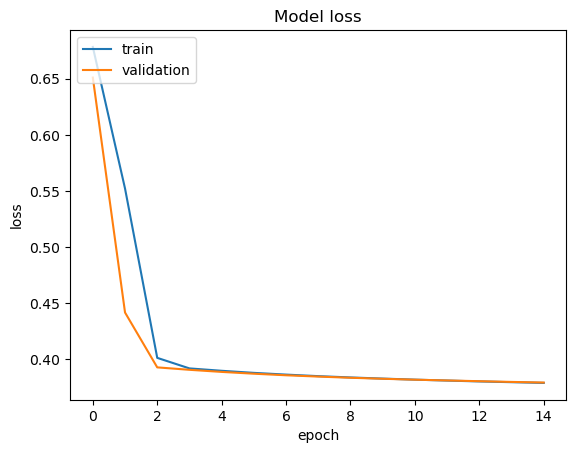

In [85]:
# plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

I guess this model loss is the best so far. So, I will use this model.

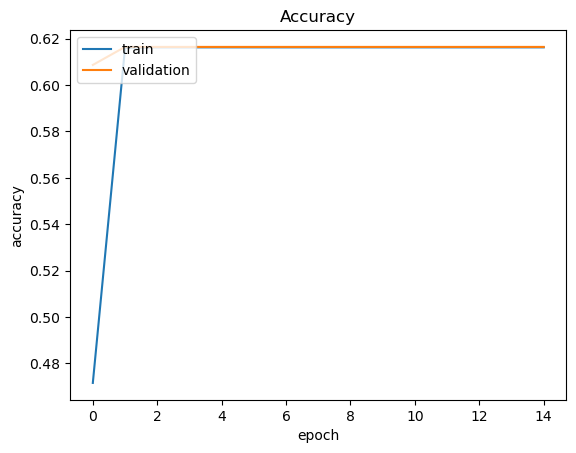

In [84]:
# plot training and validation loss
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
# getting the product and department 
products = pd.read_csv('products.csv')
dept = pd.read_csv('departments.csv')
prod_dept = pd.merge(products, dept, on='department_id', how='left')

In [90]:
def recommend_product(uid, df):
    """ 
    Args:
        uid: user_id
    Returns:
        5 products with high ratings from user and 10 products recommendations
    """
    # get a user id
    user_id = uid
    # get user_id information
    products_bought_by_user = df[df.user_id == user_id]
    # taking only the products that has not been bought by the user
    products_not_bought = prod_dept[
        ~prod_dept["product_id"].isin(products_bought_by_user.product_id.values)]["product_id"]
    products_not_bought = list(
        set(products_not_bought).intersection(set(product2product_encoded.keys()))
    )
    products_not_bought = [[product2product_encoded.get(x)] for x in products_not_bought]
    
    # getting the user encoder
    user_encoder = user2user_encoded.get(user_id)
    # getting an array of list product that has not been bought 
    user_product_array = np.hstack(
        ([[user_encoder]] * len(products_not_bought), products_not_bought)
    )
    # model predict
    ratings_pred = model.predict(user_product_array).flatten()
    # get the index
    top_ratings_indices = ratings_pred.argsort()[-10:][::-1]
    # get the product_id
    recommended_product_ids = [
        product_encoded2product.get(products_not_bought[x][0]) for x in top_ratings_indices
    ]

    print("Showing recommendations for user_id: {}".format(user_id))
    print("====" * 15)
    print("Products with high ratings from user")
    print("----" * 15)
    # get 5 products highly rated by users
    top_products_user = (
        products_bought_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .product_id.values
    )
    # link in product_id with product department
    prod_dept_rows = prod_dept[prod_dept["product_id"].isin(top_products_user)]
    for row in prod_dept_rows.itertuples():
        print(row.product_name, ":", row.department)

    print("----" * 15)
    print("Top 10 product recommendations")
    print("----" * 15)
    # link in recommended product_id with product department
    recommended_products = prod_dept[prod_dept["product_id"].isin(recommended_product_ids)]
    for row in recommended_products.itertuples():
        print(row.product_name, ":", row.department)
    

In [91]:
recommend_product(1, rating_)

1527/1527 [==============================] - 2s 1ms/step
Showing recommendations for user_id: 1
Products with high ratings from user
------------------------------------------------------------
Soda : beverages
Pistachios : snacks
Original Beef Jerky : snacks
Organic String Cheese : dairy eggs
Zero Calorie Cola : beverages
------------------------------------------------------------
Top 10 product recommendations
------------------------------------------------------------
Italian Sparkling Mineral Water : beverages
Bag of Organic Bananas : produce
Spring Water : beverages
Organic Baby Spinach : produce
Banana : produce
Organic Raspberries : produce
Organic Reduced Fat Milk : dairy eggs
Sparkling Water Grapefruit : beverages
Organic Hass Avocado : produce
Organic Avocado : produce


For FunkSVD and ALS, we only use 100,000 of data due to computational limitation. They both have low accuracies, it might be because we train on such little data. Meanwhile, using neural network, we can use much larger data and has better accuracy than FunkSVD and ALS.
- The fcp score for FunkSVD is 0.245
- The rmse score for ALS is 0.169
- The binary accuracy for Neural Network is 0.6165
